stroke prediction


,Shapiro-Wilk Stat,Shapiro-Wilk p-value,D’Agostino’s K^2 Stat,D’Agostino’s K^2 p-value,Skewness,Kurtosis,Anderson-Darling Stat,AD Crit Val (15.0%),AD Crit Val (10.0%),AD Crit Val (5.0%),AD Crit Val (2.5%),AD Crit Val (1.0%)
age,0.967706,7.769296e-29,834.791088,5.338492e-182,-0.126390,-0.986487,25.485841,0.575,0.655,0.786,0.917,1.091
bmi,0.952356,5.720257e-34,867.949773,3.365903e-189,1.081712,3.724791,25.742231,0.575,0.655,0.786,0.917,1.091
avg_glucose_level,0.923436,7.892253e-41,411.626274,4.135140e-90,0.908018,0.254141,94.712887,0.575,0.655,0.786,0.917,1.091


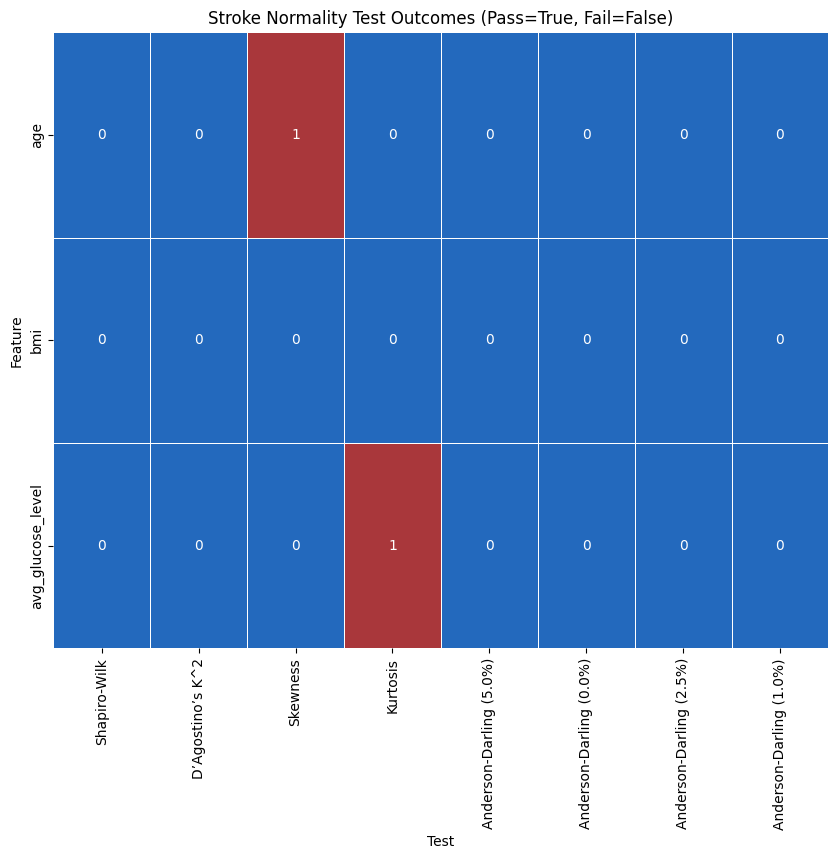

fetal health classification


,Shapiro-Wilk Stat,Shapiro-Wilk p-value,D’Agostino’s K^2 Stat,D’Agostino’s K^2 p-value,Skewness,Kurtosis,Anderson-Darling Stat,AD Crit Val (15.0%),AD Crit Val (10.0%),AD Crit Val (5.0%),AD Crit Val (2.5%),AD Crit Val (1.0%)
baseline value,0.994178,3.214570e-06,7.534838,2.311164e-02,0.012375,-0.285480,2.960074,0.575,0.654,0.785,0.916,1.089
accelerations,0.810772,9.602117e-41,277.573509,5.317142e-61,1.178672,0.657825,116.965786,0.575,0.654,0.785,0.916,1.089
fetal_movement,0.194646,0.000000e+00,2338.427001,0.000000e+00,7.990625,68.065962,494.025197,0.575,0.654,0.785,0.916,1.089
uterine_contractions,0.956695,4.613025e-22,75.959178,3.203864e-17,0.125654,-0.657828,19.965258,0.575,0.654,0.785,0.916,1.089
light_decelerations,0.700841,0.000000e+00,523.127581,2.536817e-114,1.704940,2.454861,204.736553,0.575,0.654,0.785,0.916,1.089
severe_decelerations,0.027761,0.000000e+00,3627.779109,0.000000e+00,18.357640,335.002950,655.065592,0.575,0.654,0.785,0.916,1.089
prolongued_decelerations,0.305910,0.000000e+00,1472.759101,0.000000e+00,4.188728,19.220331,532.334549,0.575,0.654,0.785,0.916,1.089
abnormal_short_term_variability,0.969158,1.305985e-18,427.483538,1.489804e-93,-0.027139,-1.025013,17.936478,0.575,0.654,0.785,0.916,1.089
mean_value_of_short_term_variability,0.877912,1.444790e-34,608.741471,6.508324e-133,1.689117,4.953433,39.791214,0.575,0.654,0.785,0.916,1.089
percentage_of_time_with_abnormal_long_term_variability,0.605688,0.000000e+00,761.230848,5.021363e-166,2.254778,4.567774,272.814184,0.575,0.654,0.785,0.916,1.089


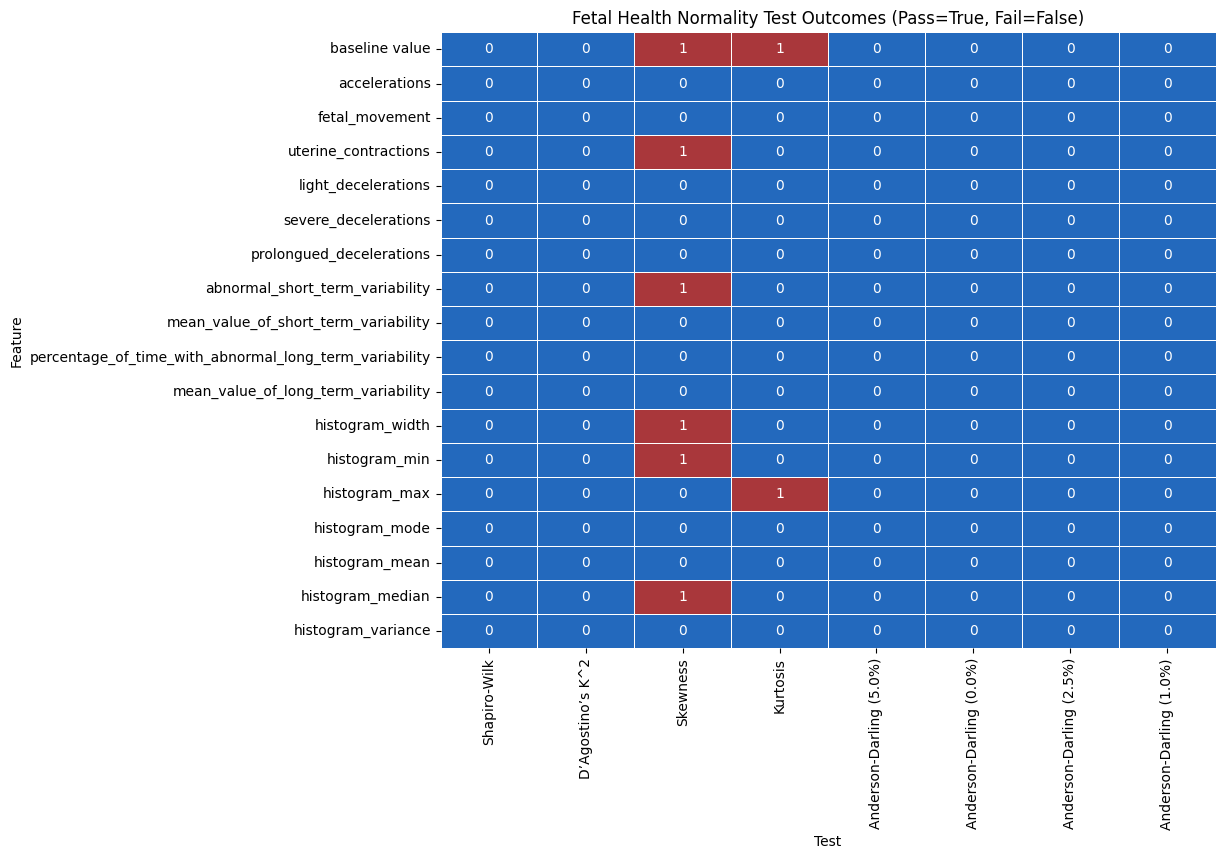

In [1]:
import sys

import pandas as pd
from scipy import stats

sys.path.append('..')
from utils import load_data, FetalHealthParams, StrokeParams


import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(metrics_df, dataset_name):
    # Create a binary outcome DataFrame based on pass/fail conditions for each test
    binary_outcomes = pd.DataFrame(index=metrics_df.index)

    # Shapiro-Wilk p-value > 0.05 indicates normal distribution
    binary_outcomes['Shapiro-Wilk'] = metrics_df['Shapiro-Wilk p-value'] > 0.05

    # D'Agostino's K^2 p-value > 0.05 indicates normal distribution
    binary_outcomes['D’Agostino’s K^2'] = metrics_df['D’Agostino’s K^2 p-value'] > 0.05

    # Skewness near 0 indicates symmetry hence more likely to be normal
    binary_outcomes['Skewness'] = abs(metrics_df['Skewness']) < 0.5

    # Kurtosis near 0 indicates a distribution similar to normal distribution
    binary_outcomes['Kurtosis'] = abs(metrics_df['Kurtosis']) < 0.5

    for critical_value in metrics_df.columns[metrics_df.columns.str.contains('AD Crit Val')]:
        binary_outcomes[f'Anderson-Darling ({critical_value[-5:-2]}%)'] = metrics_df['Anderson-Darling Stat'] < metrics_df[critical_value]
    # ad_5_critical = metrics_df['AD Crit Val (5.0%)']
    # binary_outcomes['Anderson-Darling'] = metrics_df['Anderson-Darling Stat'] < ad_5_critical

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(binary_outcomes, cmap="vlag", annot=True, cbar=False, linewidths=.5)
    plt.title(f'{dataset_name} Normality Test Outcomes (Pass=True, Fail=False)')
    plt.xlabel('Test')
    plt.ylabel('Feature')
    plt.show()


def main(args):
    data, target = load_data(args.data_train, args.target_column)
    data.drop(columns=args.cat_cols, inplace=True)
    # Create an empty DataFrame to store the results
    metrics_df = pd.DataFrame()

    # Loop through each column in the DataFrame
    for col in data.columns:
        # Calculate metrics for each column
        shapiro_stat, shapiro_p = stats.shapiro(data[col])
        dagostino_stat, dagostino_p = stats.normaltest(data[col])
        skewness = stats.skew(data[col])
        kurtosis = stats.kurtosis(data[col])
        anderson_result = stats.anderson(data[col])

        # Prepare to store all critical values and corresponding significance levels from Anderson-Darling Test
        ad_critical_values = dict(zip(anderson_result.significance_level, anderson_result.critical_values))

        # Compile metrics into a dictionary, including all Anderson-Darling critical values
        metrics = {
            'Shapiro-Wilk Stat': shapiro_stat,
            'Shapiro-Wilk p-value': shapiro_p,
            'D’Agostino’s K^2 Stat': dagostino_stat,
            'D’Agostino’s K^2 p-value': dagostino_p,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Anderson-Darling Stat': anderson_result.statistic,
        }

        # Adding Anderson-Darling critical values and significance levels to metrics dictionary
        for sig_level, crit_value in ad_critical_values.items():
            metrics[f'AD Crit Val ({sig_level}%)'] = crit_value

        # Add the dictionary as a new row in the DataFrame
        metrics_df[col] = pd.Series(metrics)

    # Transpose the DataFrame so that metrics are rows and features are columns
    metrics_df = metrics_df.T

    # Display the results
    display(metrics_df)

    plot_heatmap(metrics_df, args.target_column.replace("_", " ").title())

if __name__ == '__main__':
    print("stroke prediction")
    stroke_args = StrokeParams()
    main(stroke_args)

    print("fetal health classification")
    fetal_health_args = FetalHealthParams()
    main(fetal_health_args)